# Preamble

In [ ]:
import torch
import numpy as np
import seaborn as sns
import scipy.sparse as sp
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from hierarchical_smoothing.datasets import *
from hierarchical_smoothing.utils import *
from hierarchical_smoothing.images.models import *
from hierarchical_smoothing.images.training import *
from hierarchical_smoothing.images.smoothing import *
from hierarchical_smoothing.cert import certify

In [ ]:
%env CUBLAS_WORKSPACE_CONFIG=:4096:8 

# Model

In [ ]:
hparams = {
    "device": "cuda",
    "datatype": "images",
    "dataset_path": "../data/images/",

    "dataset": "CIFAR10",
    "dataset_mean": [0.4914, 0.4822, 0.4465],
    "dataset_std": [0.2023, 0.1994, 0.2010],

    # model
    "arch": "ResNet50",
    "protected": True,
    "in_channels": 4,
    "out_channels": 10,

    # training
    "batch_size_training": 128,
    "batch_size_inference": 300,
    "lr": 0.01,
    "momentum": 0.9,
    "weight_decay": 5e-4,
    "max_epochs": 400,
    "early_stopping": 400,
    "lr_scheduler": "cosine",
    "logging": True,

    "alpha": 0.01,
    "n0": 1_000,
    "n1": 10_000,

    "smoothing_config" : {
        "smoothing_distribution": "hierarchical_gaussian",
        "append_indicator": True,
        "k": 150,
        "std": 0.25,
        "d": 1024
    }
}

In [ ]:
seed = 42
set_random_seed(seed)

# train_data, test_data_small, test_data = load_dataset(hparams, seed=seed)
# model = create_image_classifier(hparams)
# model = train_image_classifier(model, train_data, hparams)

In [ ]:
# We provide pretrained models for efficient demonstration. If you want to use this pretrained ResNet50 model, execute the following before:
# wget --show-progress -qO data/precomputed/pretrained_ResNet50_CIFAR10.pt https://www.dropbox.com/scl/fi/el5onf6nha1wb16ro7e8h/pretrained_ResNet50_CIFAR10.pt?rlkey=xac8by8b7blz88st1a7h7e1nz
model = torch.load("../data/precomputed/pretrained_ResNet50_CIFAR10.pt")

# Smoothed Predictions (Inference)

In [ ]:
# pre_votes, targets = smooth_image_classifier(hparams, model, test_data_small, hparams["n0"])
# votes, _ = smooth_image_classifier(hparams, model, test_data_small, hparams["n1"])

In [ ]:
pre_votes, targets, votes = torch.load("../data/precomputed/precomputed_votes_ResNet50_CIFAR10.pt")

In [ ]:
y_hat = pre_votes.argmax(1)
y = torch.tensor(targets)
correct = (y_hat == y).numpy()
clean_acc = correct.mean()
print(f"Clean ACC on test subset: {clean_acc}")

Clean ACC on test subset: 0.891


# Certificate

In [ ]:
certificates = certify(correct, votes, pre_votes, hparams)

In [ ]:
density = 0.01
max_eps = 1.3
plot_data = {}

for r in range(1,5):
    xticks = np.arange(0,max_eps+density*10, density)

    cert_accs = []
    for x in xticks:
        radius = (r,x)
        certified = np.array(certificates["multiclass"][radius[0]]) >= radius[1]
        cert_acc = (certified * correct).mean()
        cert_accs.append(cert_acc)
    plot_data[r] = cert_accs

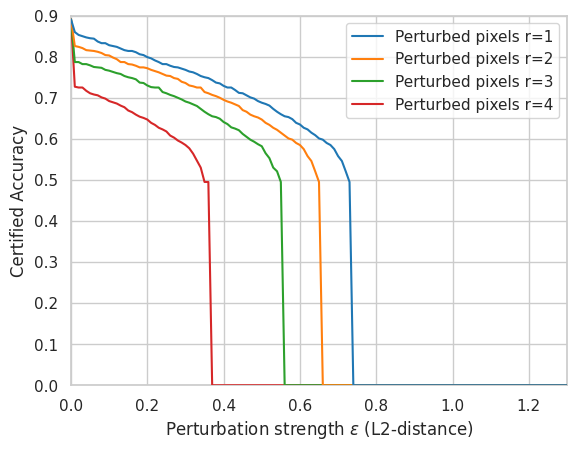

In [ ]:
sns.set_style("whitegrid")
sns.set_context("notebook")
fig, ax = plt.subplots(1,1)

for radius in plot_data:
    label = f"Perturbed pixels r={radius}"
    plt.plot(xticks, plot_data[radius], label=label,zorder=100-radius)

plt.ylim((0, 0.9))
plt.xlim(0,max_eps)
plt.xticks(np.arange(0,max_eps+0.1, 0.2))
ax.set_xlabel("Perturbation strength $\epsilon$ (L2-distance)")
ax.set_ylabel("Certified Accuracy")
ax.legend()
plt.show()